In [1]:
import itertools
import warnings
from time import time

import numpy as np
import pandas as pd
import seaborn as sns

from src.config import BLD, SRC
from src.estimation.gridsearch import (
    get_mask_around_diagonal,
    run_1d_gridsearch,
    run_2d_gridsearch,
)
from src.estimation.msm_criterion import (
    get_index_bundles,
    get_parallelizable_msm_criterion,
)
from src.manfred.shared import hash_array
from src.plotting.msm_plots import plot_estimation_moment, plot_infection_channels
from src.simulation.load_params import load_params
from src.simulation.load_simulation_inputs import load_simulation_inputs

DEBUG = True
SIM_START = pd.Timestamp("2020-09-15")
SIM_END = pd.Timestamp("2020-09-20")

warnings.filterwarnings(
    "ignore", message="indexing past lexsort depth may impact performance."
)
%load_ext snakeviz

# Load the simulation inputs

In [2]:
params = load_params("baseline")
simulate_kwargs = load_simulation_inputs(
    scenario="baseline",
    start_date=SIM_START,
    end_date=SIM_END,
    debug=DEBUG,
)
pmsm = get_parallelizable_msm_criterion(simulate_kwargs, "gridsearch")

# Modify Params

In [3]:
index_bundles = get_index_bundles(params)
hh_probs = index_bundles["hh"]
school_probs = index_bundles["school"]
young_educ_probs = index_bundles["young_educ"]
work_probs = index_bundles["work"]
other_probs = index_bundles["other"]
free_probs = [bundle[0] for bundle in index_bundles.values()]

In [4]:
params.loc[other_probs, "value"] = 0.16  # Done
params.loc[young_educ_probs, "value"] = 0.005
params.loc[school_probs, "value"] = 0.01
params.loc[work_probs, "value"] = 0.15
params.loc[hh_probs] = 0.095
params.loc[free_probs]

value
category       subcategory         name                      
infection_prob educ_school_0       educ_school_0        0.010
               educ_preschool_0    educ_preschool_0     0.005
               households          households           0.095
               work_non_recurrent  work_non_recurrent   0.150
               other_non_recurrent other_non_recurrent  0.160

# Run estimation

In [5]:
dimensions = "2d"

n_gridpoints = 2
loc1 = (school_probs,)
gridspec1 = (0.005, 0.015, n_gridpoints)
# only used if 2d
loc2 = (work_probs,)
gridspec2 = (0.14, 0.16, n_gridpoints)

n_seeds = 3
n_cores = 6

mask = get_mask_around_diagonal(n_gridpoints, offset=0, flip=True)

In [6]:
if dimensions == "2d":
    results, grid, best_index, fig = run_2d_gridsearch(
        func=pmsm,
        params=params,
        loc1=loc1,
        gridspec1=gridspec1,
        loc2=loc2,
        gridspec2=gridspec2,
        n_seeds=n_seeds,
        n_cores=n_cores,
        mask=mask,
    )
else:
    results, grid, best_index, fig = run_1d_gridsearch(
        func=pmsm,
        params=params,
        loc=loc1,
        gridspec=gridspec1,
        n_seeds=n_seeds,
        n_cores=n_cores,
    )

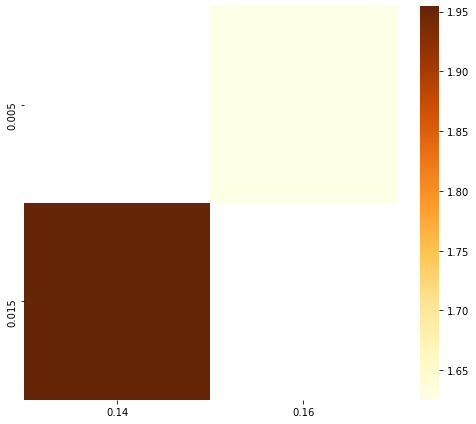

In [7]:
fig

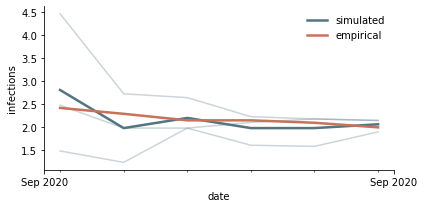

In [8]:
plot_estimation_moment(results[best_index], "aggregated_infections")

In [9]:
# plot_infection_channels(results[best_index], aggregate=True)